# T1 - Defining a model

_This tutorial assumes that you have already installed Atomica_

Atomica is a Python-based toolbox for simulating compartment models, primarily in epidemiology. The Cascade Analysis Tool is a web application that uses Atomica to perform simulations. 

![t1-atomica-overview](assets/T1/t1_atomica_overview.png)

On the input side, Atomica takes in three Excel files. These are

- The **framework file**, which specifies the model itself
- The **databook**, which takes in values for model parameters
- The **program book**, which both defines available programs and takes in values (spending and effects)

![t1-atomica-tasks](assets/T1/t1_atomica_tasks.png)

In this tutorial, we will go through the process of implementing a basic SIR model with population dynamics and transmission dynamics.

The first step in implementing a disease model is to plan the dynamics of the disease itself. There are broadly two types of models

- Models that track a single group of people over time, without any new people entering the model, so the total number of people is fixed (cohort model)
- Models in which there are population dynamics and the total number of people in the system changes over time

Typically, simple cascade models looking at comparing intervention modalities over short timeframes can use the former approach, while transmission models examining longer timeframes would use the latter approach. We will implement the SIR model using the latter approach here, which can be trivially simplified into the former approach if required. 

Atomica enforces a separation between the sequence of disease states (the states that an individual can be in) and population groups, which are effectively copies of the set of disease sets. Different population groups tend to be used for

- Age stratification (e.g. children vs adults)
- Risk stratification (e.g. PLHIV, prisoners)

The main point to keep in mind at the initial stage of designing the compartment structure of the disease is that the structure is replicated across populations. In the second stage of model design, we think about interactions between populations and movement of people between populations (e.g. aging, HIV infection, incarceration), but at the initial stage, we focus on the flow of the disease itself.

Thus, the first step in model development is to design the compartment structure representing individual stages. For the SIR model, this corresponds to 'susceptible, 'infected', and 'recovered'. These are all of the states that we would need in order to implement a simple cohort model. 

![t1-schematic-1](assets/T1/t1_schematic_1.png)

For a fully dynamic model, we need to also account for births and deaths. These are implemented as special compartments. Source compartments (used to model births, and external migration) have an inexhaustible supply of people, and people in sink compartments (used to model deaths, emigration) do not count towards to the total population size. Transitions into source compartments are prohibited, as are transitions out of sink compartments.

![t1-schematic-2](assets/T1/t1_schematic_2.png)

We also need to outline the transitions between compartments in the model. Each arrow on the diagram is referred to as a _link_. The value of each link - that is, the number of people that are moved from one compartment to another via that arrow in a single timestep - is governed by a _parameter_. The parameters correspond to the labels on the diagram. Note that

- The same parameter can be used for multiple links. For example, we can define a single background death rate ('Other death') and have that death rate apply to everyone in the model
- If desired, more than one link can govern transitions between the same compartments. For example, we have two arrows between 'Infected' and 'Death', one corresponding to the background death rate, and one correponding to deaths due to disease

Parameters underpin a lot of the flexibility in Atomica, because their values can be computed dynamically depending on other quantities in the model. However, at this stage, it is sufficient to simply work out which parameters are required for the transitions in the model. 

With this initial model structure in hand, we can begin implementation in Atomica by writing a framework file. Inside the Atomica repository are templates for new frameworks. These are

- `atomica/library/framework_template.xlsx`, which is a minimal framework oriented for use in the Cascade Analysis Tool
- `atomica/library/framework_template_advanced.xlsx`, which contains all possible data entry fields

For backend use, start with the advanced template - most columns can be left empty, but it is useful to know that they can be used if required.

When opening the framework file, there are a number of sheets available. At this initial stage, we only need to focus on three sheets

- Compartments
- Parameters
- Transitions

To start with, we need to specify the compartments in the model. We provide both a short name (used internally, easy to read and type) and a display name (used for plotting and presentation). Further, we also need to mark the source and sink compartments. The completed compartments sheet for the model schematic above is shown below.

![t1-framework-1](assets/T1/t1_framework_1.png)

Next, we need to define the parameters in the model. Our initial pass at filling out the parameters sheet will focus on the parameters that we require for transitions. For parameters associated with transitions, we need to specify what units they are in. The 4 available unit types are

- Number (default is per year)
- Probability (default is per year) - this annual probability gets converted to a per-timestep proportion, preserving the annual probability of leaving the compartment (see [here](http://atomica.tools/docs/mnch_extensions/examples/Probability-Rescaling.html) for further information on this calculation)
- Duration (default is years) - this is equal to the inverse of the probability, it corresponds to the mean time spent in the compartment
- Proportion (time-invariant, used only for junction compartments - discussed later)

Since we cannot define a proportion of a source compartment (as the source compartment represents an infinite reservoir of people), the outflows from the source compartment must come from parameters in 'number' units. For the other transitions, we could choose any units (apart from proportion) depending on available data or what would be easiest to calculate. Probability tends to be the simplest to work with in models, but harder to obtain data for. In this case, we will specify all of the remaining quantities in probability units. Our framework now has the following content on the parameters sheet:

![t1-framework-2](assets/T1/t1_framework_2.png)

Next, we need to fill out the transitions sheet. The transitions sheet contains a matrix with the names of all of the compartments in the model in the first row and first column. Each cell represents a transition from the row compartment, to the column compartment. If a transition between compartments exists, enter the name of the parameter(s) governing that transition in the cell. For the compartments and parameters defined above, the transition structure in the framework is as follows:

![t1-framework-3](assets/T1/t1_framework_3.png)

This is a matrix/table representation of the location of the arrows in the original schematic diagram. Notice how a comma separated list of parameters `'doth_rate,m_rate'` is used for the transition between `inf` and `death`, which has two arrows in the schematic.

Finally, in order to run a simulation, we need to specify 

- the values of the parameters
- the initial compartment sizes

Broadly, there are two ways of specifying the values of a parameter. For some parameters, the user should explicitly specify the value in the databook. For other parameters, the value needs to be calculated based on the current state of the model. For the parameters in our model, all parameters would be suitable to directly have values entered by the user, except for the force of infection, which depends on the prevalence. Further, we might also expect that it would depend on the infectiousness of the disease, which the user would need to enter. 

If a parameter (or other quantity) needs to appear in the databook, we need to assign it to a sheet in the databook. In the framework file, the 'Databook Pages' sheet specifies which sheets should be generated in the databook. Then, on the parameters sheet, you can enter the name of a databook page to have a quantity appear on that page. By default, the databook pages are 'stocks' and 'flows', intended for compartments and parameters respectively. However, you can have as many or as few pages as required, depending on what layout would be most logical and useful for users filling out the databook. Some common choices would be

- Grouping related quantities (e.g. quantities relating to latent infection, quantities related to active infection)
- Separating quantities that the user is more or less likely to need to edit (e.g. a separate sheet for constants they are unlikely to need to change)

If you specify a 'default value' for a quantity in the framework, then that quantity will be pre-filled in the databook. This can be useful for constants that the user is likely to need to modify. We will introduce an 'infectiousness' parameter, and assign databook pages for all of the quantities that need to appear in the databook. We will also enter default values for infectiousness and the background death rate, to illustrate how these are pre-filled. The parameters sheet now reads:

![t1-framework-4](assets/T1/t1_framework_4.png)

Lastly, we need to define the force of infection. This is done by entering a formula to calculate the value of the `foi` parameter at each timestep. The formula can refer to any other parameter or compartment in the model. Suppose that the probability of being infected was given by the infectiousness multiplied by the prevalance. The prevalance is given by dividing the number of people infected by the sum of all people in the model. So a suitable formula to use would be `infx*inf/(sus+inf+rec)` and we can enter this as the parameter's function. So our parameters sheet finally reads:

![t1-framework-5](assets/T1/t1_framework_5.png)

On the compartments sheet, we need to obtain the initial compartment sizes via the databook. At least one compartment needs to have a value drawn from the databook (although this can be done indirectly, as we will see later on). This can be done by entering a databook page for the compartment. Otherwise, if a compartment does not have any databook information provided in order to initialize it, it will be assigned an initial value of 0. Our compartment sheet is then finally:

![t1-framework-6](assets/T1/t1_framework_6.png)

Lastly, the 'Characteristics' sheet contains some placeholder content in the template. As we do not have any characteristics yet, remove all of the rows other than the header row. Similarly, remove the placeholder content in the 'Interactions' sheet, the 'Cascades' sheet, and the 'Plots' sheet.

Now we have finished writing the framework file. This example is saved in the Atomica repository under `atomica/docs/tutorial/assets/t1_framework_1.xlsx`. 

## Generating a databook

A databook is a data entry file that is generated from a framework. It contains data entry fields specific to the framework that was used to create it. The databook takes in the following information

- A specification of populations to use
- Data entry cells for each for each databook quantity in the framework, for each population in the databook
- A specification of any _transfers_ between populations (movement of people from one population to another)
- A specification of any _interactions_ between populations (like cross-population transmission)

We will discuss the latter features in the next tutorial. For now, we will only have a single population in our initial test of the model.

First, import Atomica into your workspace

In [1]:
import atomica as at

Next, load the framework file. A framework file gets loaded into a `ProjectFramework` object. When loading the framework file, it will automatically be checked for validity.

In [2]:
F = at.ProjectFramework('assets/T1/t1_framework_1.xlsx')

The warning about the characteristics being underdetermined is because we have three compartments, but the databook only contains information for two compartments, so this is warning that Atomica will make assumptions to initialize compartments where required. We will examine this in more detail in a subsequent tutorial when looking at characteristics in more detail.

Now that we have the framework loaded in, we can make a `ProjectData` object, which is the Python representation of the databook. We use the `ProjectData.new()` function to instantiate it, passing in the `ProjectFramework`. We also need to specify the years that we want to enter data for, and the number of populations that we want to have. The `ProjectData` constructor also prompts for the number of transfers - which we will set to `0` for now, and examine in more detail in the next tutorial.

<div class="alert alert-block alert-success">
The years and populations can be modified by editing the databook in Excel. Years can be easily added in just the places you need. Populations are trickier to add because they appear as a row in every table of the databook. You can modify the years and populations programatically by loading an existing databook in, which is particularly useful for adding or removing populations. However, comments in the databook will not be preserved if doing this. 
</div>

In [3]:
D = at.ProjectData.new(framework=F,tvec=[2016,2017],pops=1,transfers=0)

To save the databook, use the `ProjectData.save()` method

In [4]:
D.save('t1_temp.xlsx')

Object saved to C:\Users\romesh\projects\atomica\docs\tutorial\t1_temp.xlsx.


We can now open the databook and examine what's in it. There are three sheets

- 'Population definitions', which provides data entry to set the names of each population
- 'Stocks' and 'Flows', which are the databook pages defined on the 'Databook Pages' sheet in the framework file

We can go ahead and fill in the the population definitions sheet now with an example population, 'adults':

![t1-databook-1](assets/T1/t1_databook_1.png)

On the 'Stocks' sheet, we have two data entry tables, one for 'Susceptible', and one for 'Infected'. These are the two compartments that we had assigned databook pages for in the framework. We will again go ahead and fill in some values for these compartments.

![t1-databook-2](assets/T1/t1_databook_2.png)

When a simulation is run, the initial compartment sizes are obtained by interpolating the values entered into the databook onto the simulation start year. If only a single value is provided, that value will be used for any simulation start year. 


<div class="alert alert-block alert-success">
Uncertainty values <i>can</i> be used to account for uncertainty in Atomica results. However, this is computationally expensive and therefore is not performed automatically. Usually, the uncertainty cells can be left empty, but it is best practice to have users estimate and enter uncertainty in the databook from the outset, even if it won't be used initially.
</div>

Finally, the 'Flows' sheet with parameters has an additional data entry column for a 'constant' value. This allows time-independent constant values to be specified without having to assign them to a specific year.

![t1-databook-3](assets/T1/t1_databook_3.png)

Notice how the default values in the framework have been pre-filled in the 'constant' column. Grey cells represent cells that users do not need to enter any values for, so when filling out a databook, they can focus on just the blue cells. We will now go ahead and fill in some values for the parameters

![t1-databook-4](assets/T1/t1_databook_4.png)

Some additional things to notice in the example above

- Time-specific values take precedence over constant values. If any time-specific values are provided, the 'constant' cell in the relevant row will be locked out. It will turn red if a value has been entered in that cell, to indicate that the value won't be used
- You can add or remove years in each of the sub-tables independently. In the example above, an extra 2018 value was added for the disease recovery rate

Finally, the image above also indicates how to place comments or extra content in the databook. While comments may also be added as Excel comments, sometimes you need to put content in actual cells - for example, as part of a formula. There are two options for doing so

1. You can place content to the right of each sub-table. Place a cell containing '#ignore' at the end of the data table. After that cell, the rest of the row will be ignored.
2. You can skip an entire row by placing a '#ignore' at the start of the row. 

In general, a blank row is needed between each subtable, although there are ways around this. For more information and additional ways to use the '#ignore' directive, see the documentation page covering 'Skipping Excel cells' (under 'General'). 

If you have an entire sheet that you would like to ignore, simply put `'#ignore'` at the start of the sheet's name. 

Now that the databook has been filled out, we can use it to create a  project. The databook is available in the Atomica repository under `atomica/docs/tutorial/assets/T1/t1_databook_1.xlsx`. 

In [5]:
P = at.Project(framework=F,databook='assets/T1/t1_databook_1.xlsx')

Elapsed time for running "default": 0.00751s


When the project is loaded, a `ParameterSet` is automatically created, under `P.parsets`

In [6]:
P.parsets

#0: 'default':
[<class 'atomica.parameters.ParameterSet'>, <class 'atomica.utils.NamedItem'>,
<class 'object'>]
————————————————————————————————————————————————————————————
Methods:
  all_pars()          get_par()           save_calibration()
  calibration_spr...  load_calibration()  copy()
  sample()
————————————————————————————————————————————————————————————
Properties:
  y_factors
————————————————————————————————————————————————————————————
     created: datetime.datetime(2023, 11, 7, 13, 6, 44, 379602,
              tzinfo=tzutc())
interactions: odict()
    modified: datetime.datetime(2023, 11, 7, 13, 6, 44, 380603,
              tzinfo=tzutc())
        name: 'default'
        pars: #0: 'sus':
              [<class ' [...]
  pop_labels: ['Adults']
   pop_names: ['adults']
   pop_types: ['default']
   transfers: odict()
————————————————————————————————————————————————————————————



A `ParameterSet` contains calibration scale factors for all of the model parameters, as well as any overwrites related to parameter scenarios. This will be looked at in more detail in the calibration and scenario tutorials. Running a simulation requires specifying the `ParameterSet` (parset). When creating a project, a parset will also be created by default. You can run a simulation using this parset with: 

In [7]:
result = P.run_sim(parset='default')

Elapsed time for running "default": 0.00600s


We can now plot some results from this model:

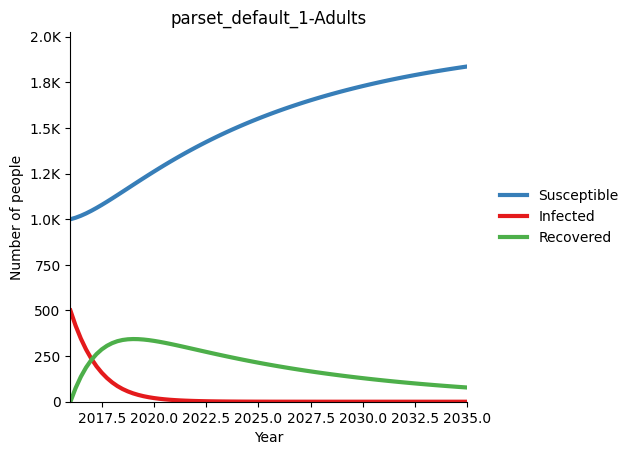

In [8]:
d = at.PlotData(result,project=P)
at.plot_series(d);

The plotting system in Atomica is fairly large - refer to the code documentation http://atomica.tools/docs/master/examples/Plotting.html for more information.

## Exercise

Write a framework file implementing the following model:

![t1-schematic-3](assets/T1/t1_schematic_3.png)

<div class="alert alert-block alert-success">
<b>Tip:</b> Use the frameworks in the Atomica library has a wide range of different types of models, and may help provide ideas of how to implement specific disease features in Atomica.
</div>


<div class="alert alert-block alert-info">
<b>Further reading:</b> What do the other columns in the framework file do? Read the <a href='https://docs.google.com/document/d/1x4Kb3hyB8NwVziE95UhT6bXpO1uRDFxJlN8QxvrLgvg/edit#heading=h.d91508a34ttz'>CAT framework file documentation </a>
</div>


<div class="alert alert-block alert-info">
<b>Further reading:</b> What Python data structure is the framework file loaded into? How do you read parts of the framework in your code? See <a href='https://docs.atomica.tools/en/master/examples/Frameworks.html'>Framework internal structure documentation</a>
</div>